With increase in the number of financial transactions, the instances of fraudulent transaction have also increased. Using machine learning algorithms we will train the dataset to identify fraudulent transactions. The dataset is obtained from Kaggle.com containing information about credit card transactions made by European cardholders in September 2013 that occured in 2 days. It contains 31 features and 284,807 transactions, out of which 492 are fraudulent. The minority class denoted by 1 in the dataset accounts for only 0.17% of the total transactions, making it highly skewed. Such problems of class imbalance are also seen in face anomaly detection.

To deal with the problem of class imbalance we have considered two techniques:
- Undersampling: Randomly picked samples of the majority class equal to the number of samples of minority class.
- Oversampling (using SMOTE): SMOTE is a neural network that artificially synthesize samples of minority class equal to the number of the samples of majority class. 

In both the approaches, the number of majority and minority classes are made equal. We will train the data on the original, undersampled, and oversampled datasets and compare them. 20% of the dataset will be used as testset and rest as training set. In the case of undersampling, 492 samples of the majority class are randomly picked, and the entire dataset (containing both the majority and minority class) is divided into training and test sets. 

In the case of oversampling, however, we have taken a little different approach. If we consider the original dataset and apply SMOTE on the minority class, the entire dataset will be overwhelmingly large, accounting for large training time and therefore, the slowdown of the process. To avoid this, we have randomly picked half of the samples from both the classes, maintaining the ratio of minority to majority class. The dataset is divided into training and test sets. Then, we have applied SMOTE on training set which synthesized minority class equal to the majority class. This way, the number of samples have not exceeded the original samples (the training set) and a fair training time is achieved. 

The original features range from V1 to V28 which are reduced (using PCA) due to confidentiality issues. Additionally there are time, amount, and class features. The class goes to the output part - Y. Time is the number of seconds elapsed between this transaction and the first transaction in the dataset. Amount is the transaction amount. The non-fraudulent or normal transaction is denoted by 0, and fraudulent transaction by 1. 

We have used PCA and t-SNE (only on undersampled data sinced t-SNE takes huge time with large data) for visualization purpose in 2D. SVM, Random Forest, and XGBoost are used for training. AUPRC, AUROC, and, Accuracy are used as metrics for model evaluation. In case of original data with class imbalance, accuracy is an useless metric for evaluation, rather, AUPRC is more appropriate. ROC curve is also plotted for each model. The feature correlation is explained by plotting Confusion Matrix, though it proved useless for the original dataset with high class imbalance. 

A final report is linked with the repository which will summarize the project. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

Text(0.5, 1.0, 'Class Imbalance')

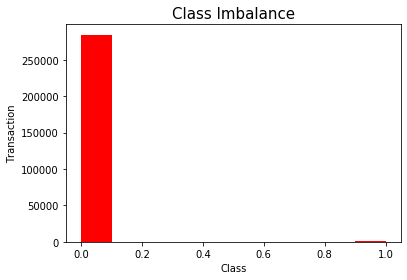

In [5]:
plt.hist(data['Class'], color='red')
plt.xlabel('Class')
plt.ylabel('Transaction')
plt.title('Class Imbalance', fontsize=15)

In [6]:
pc_fraud = len(data.loc[data['Class'] == 1].values)/len(data.loc[data['Class'] == 0].values)

In [7]:
pc_fraud*100

0.17304750013189596

In [8]:
data.isnull().sum().max()

0

In [9]:
isFraudAmt = data.loc[data['Class']==1]['Amount']

Text(0.5, 1.0, 'Fraudulent Transaction')

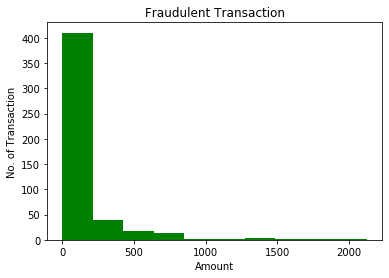

In [10]:
plt.hist(isFraudAmt, color='green')
plt.xlabel('Amount')
plt.ylabel('No. of Transaction')
plt.title('Fraudulent Transaction')

In [11]:
notFraudAmt = data.loc[data['Class']==0]['Amount']

Text(0.5, 1.0, 'Non-Fraudulent Transaction')

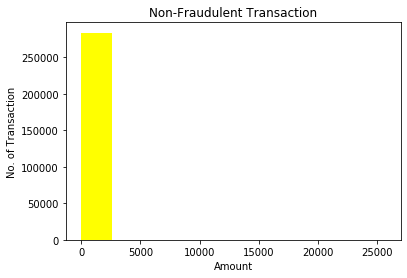

In [12]:
plt.hist(notFraudAmt, color='yellow')
plt.hist(isFraudAmt, color='green')
plt.xlabel('Amount')
plt.ylabel('No. of Transaction')
plt.title('Non-Fraudulent Transaction')

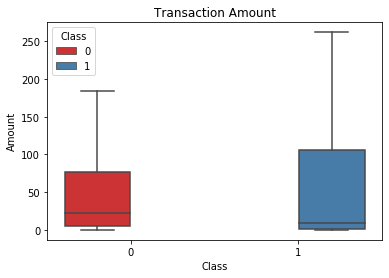

In [13]:
s = sns.boxplot(x="Class", y="Amount", hue="Class",data=data, 
                palette="Set1",showfliers=False).set_title("Transaction Amount")


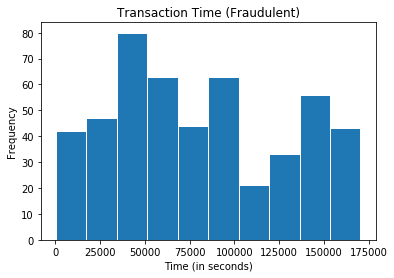

In [14]:
plt.hist(data.loc[data['Class']==1]['Time'], edgecolor='white')
plt.xlabel('Time (in seconds)')
plt.ylabel('Frequency')
plt.title('Transaction Time (Fraudulent)')
plt.show()

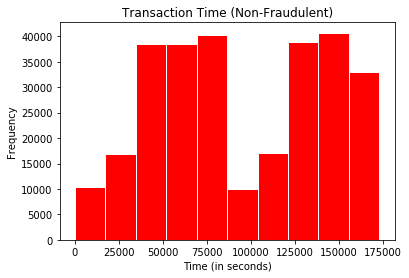

In [15]:
plt.hist(data.loc[data['Class']==0]['Time'], edgecolor='white', color='red')
plt.xlabel('Time (in seconds)')
plt.ylabel('Frequency')
plt.title('Transaction Time (Non-Fraudulent)')
plt.show()

In [3]:
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

In [4]:
data['Norm_Amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))

In [5]:
data['Norm_Time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

In [6]:
data.drop(['Time','Amount'], axis=1, inplace=True)

In [7]:
data = data.sample(frac=1)

In [8]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

### Dimensionality Reduction using PCA

In [8]:
x = data.drop('Class', axis=1)
y = data['Class']

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)

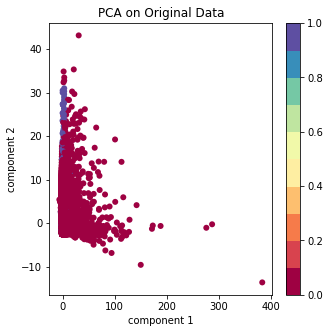

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(x_pca[:,0], x_pca[:,1], c=y, edgecolor='none',
        cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA on Original Data')
plt.colorbar()

## Classification with Original Data

In [22]:
x = data.drop('Class', axis=1).values
y = data['Class'].values

In [23]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

### Support Vector Machine

In [24]:
from sklearn.svm import SVC
svc = SVC()

In [25]:
svc.fit(xtrain, ytrain)

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [26]:
ypred = svc.predict(xtest)

In [30]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.6080700168098147
AUROC score: 0.8181554389897249
Accuracy score: 0.9993153330290369
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.64      0.76        99

    accuracy                           1.00     56962
   macro avg       0.98      0.82      0.88     56962
weighted avg       1.00      1.00      1.00     56962



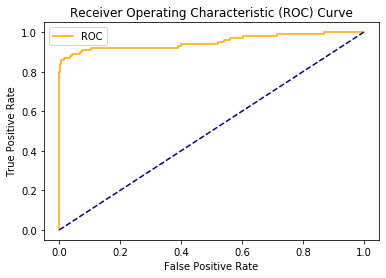

In [31]:
yscore = svc.decision_function(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore)
plot_roc_curve(fpr, tpr)

### Random Forest  Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
random_clf = RandomForestClassifier(random_state=0)

In [33]:
random_clf.fit(xtrain, ytrain)

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [34]:
ypred = random_clf.predict(xtest)

In [35]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.6905626347534989
AUROC score: 0.8686429033667133
Accuracy score: 0.9994557775359011
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.74      0.82        99

    accuracy                           1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



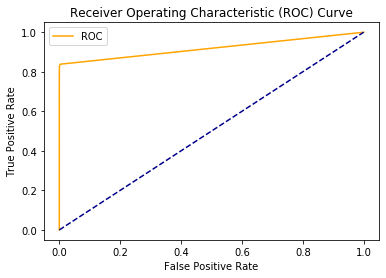

In [44]:
yscore = random_clf.predict_proba(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore[:,1])
plot_roc_curve(fpr, tpr)

### XGBoost

In [45]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [46]:
xgb.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [47]:
ypred = xgb.predict(xtest)

In [48]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.72069309083914
AUROC score: 0.8837944185182285
Accuracy score: 0.9995084442259752
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.77      0.84        99

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



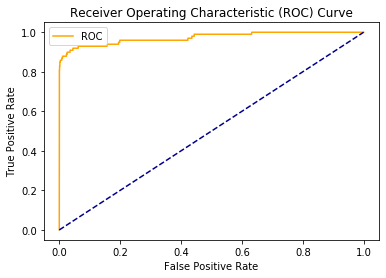

In [51]:
yscore = xgb.predict_proba(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore[:,1])
plot_roc_curve(fpr, tpr)

## Undersampled Data

In [8]:
fraud_data = data.loc[data['Class']==1]
not_fraud_data = data.loc[data['Class']==0][:492]

In [9]:
under_data = pd.concat([fraud_data, not_fraud_data])

In [10]:
under_data = under_data.sample(frac=1, random_state=0)

Text(0.5, 1.0, 'Under Sampled Data')

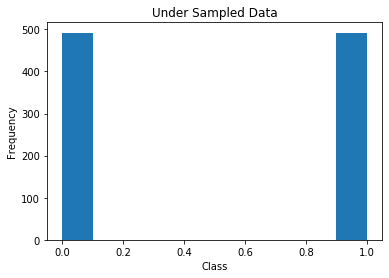

In [6]:
plt.hist(under_data['Class'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Under Sampled Data')

<Figure size 432x288 with 0 Axes>

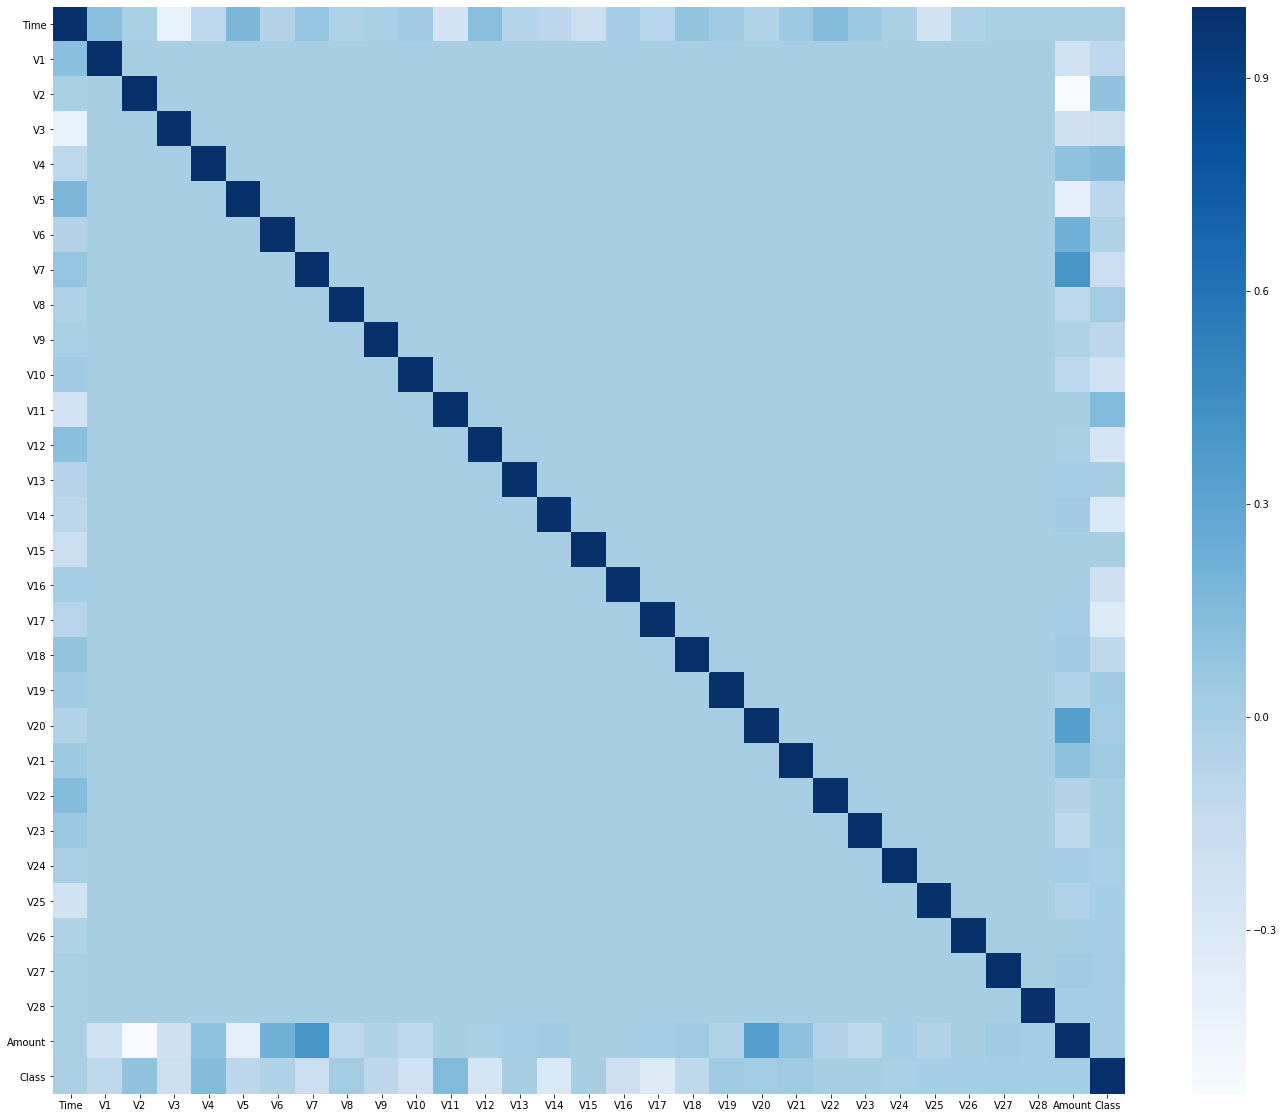

<Figure size 432x288 with 0 Axes>

In [7]:
plt.figure(figsize=(24,20))
original_corr = data.corr()
sns.heatmap(original_corr, cmap='Blues')
plt.figure('Confusion Matrix for Orginal Data')

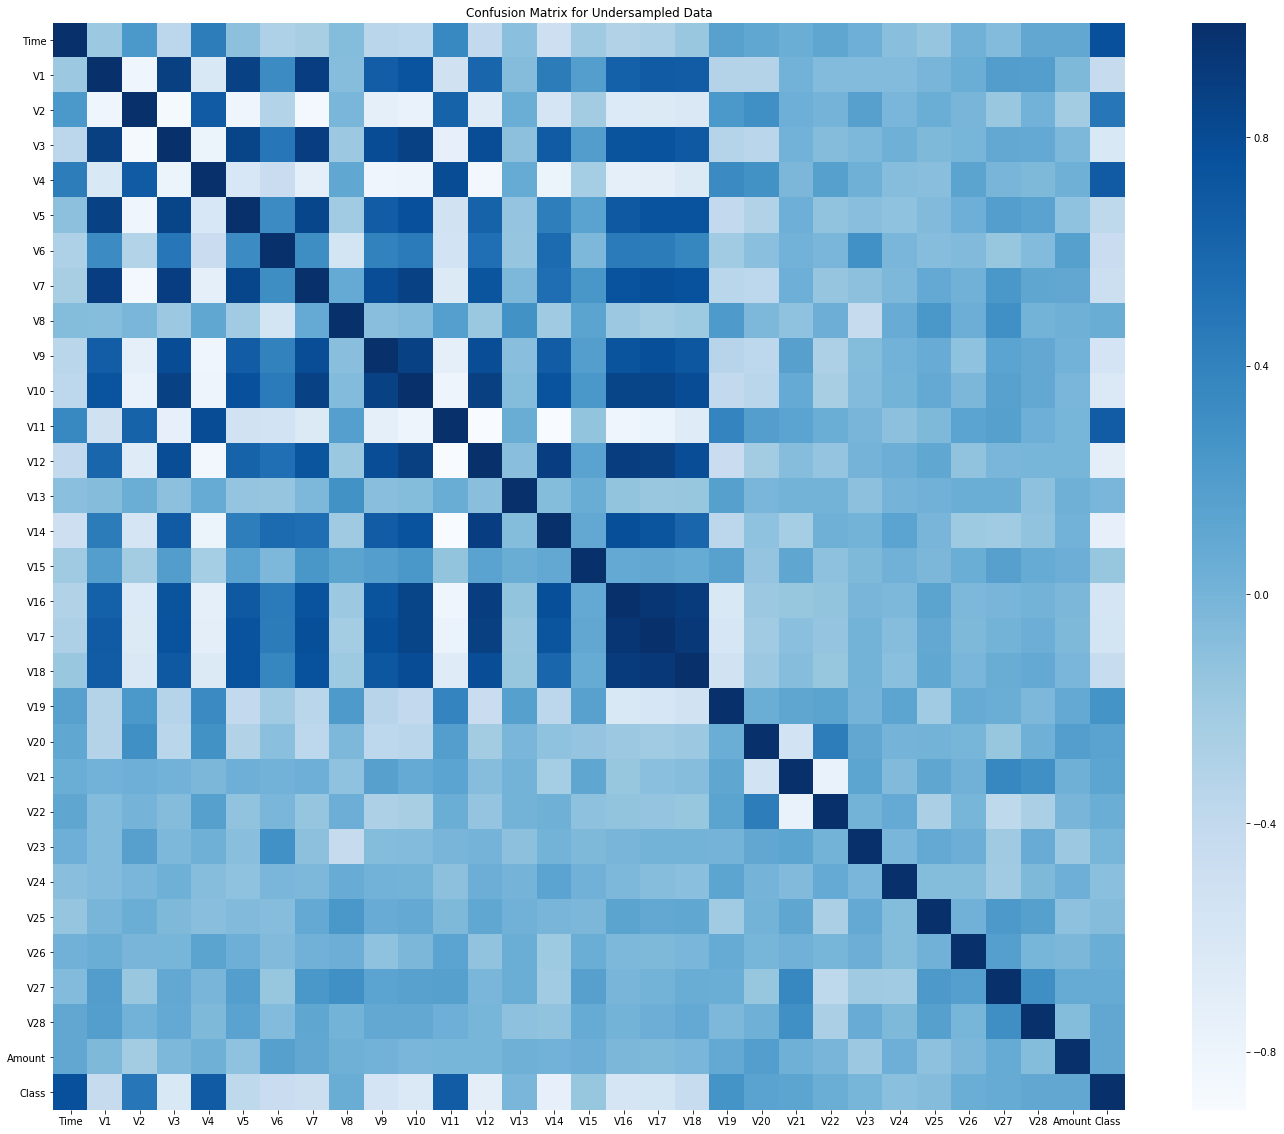

In [10]:
plt.figure(figsize=(24,20))
under_corr = under_data.corr()
sns.heatmap(under_corr, cmap='Blues')
plt.title('Confusion Matrix for Undersampled Data')
plt.show()

In [11]:
x = under_data.drop('Class', axis=1)
y = under_data['Class']

### Dimensionality Reduction using PCA and t-SNE

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_pca = pca.transform(x)

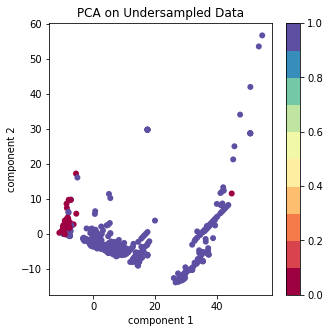

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(x_pca[:,0], x_pca[:,1], c=y, edgecolor='none',
        cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA on Undersampled Data')
plt.colorbar()

In [14]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, random_state=0).fit_transform(x)

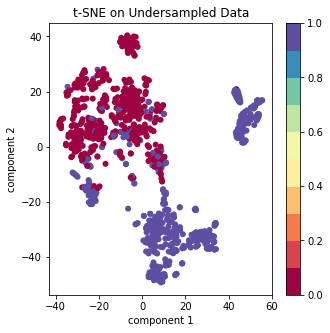

In [15]:
plt.figure(figsize=(5, 5))
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y, edgecolor='none',
        cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('t-SNE on Undersampled Data')
plt.colorbar()

In [60]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

### Support Vector Machine

In [61]:
from sklearn.svm import SVC
svc = SVC()

In [62]:
svc.fit(xtrain, ytrain)

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [63]:
ypred = svc.predict(xtest)

In [64]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.9108769591003093
AUROC score: 0.9445132013201321
Accuracy score: 0.9441624365482234
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       101
           1       0.93      0.96      0.94        96

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



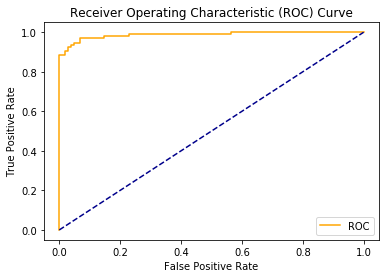

In [65]:
yscore = svc.decision_function(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore)
plot_roc_curve(fpr, tpr)

### Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
random_clf = RandomForestClassifier(random_state=0)

In [67]:
random_clf.fit(xtrain, ytrain)

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [68]:
ypred = random_clf.predict(xtest)

In [69]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.919964432473497
AUROC score: 0.949463696369637
Accuracy score: 0.949238578680203
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       101
           1       0.94      0.96      0.95        96

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



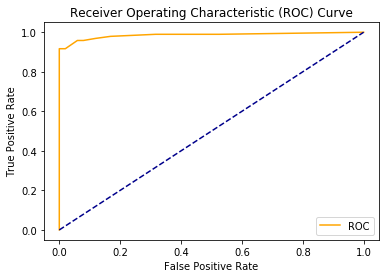

In [70]:
yscore = random_clf.predict_proba(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore[:,1])
plot_roc_curve(fpr, tpr)

### XGBoost

In [71]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [72]:
xgb.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [73]:
ypred = xgb.predict(xtest)

In [74]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.919964432473497
AUROC score: 0.949463696369637
Accuracy score: 0.949238578680203
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       101
           1       0.94      0.96      0.95        96

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



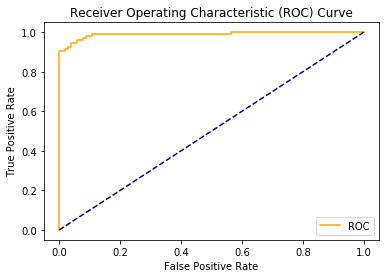

In [76]:
yscore = xgb.predict_proba(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore[:,1])
plot_roc_curve(fpr, tpr)

## Oversampled Data

In [86]:
not_fraud = data.loc[data['Class']==0]
is_fraud = data.loc[data['Class']==1]

In [87]:
not_fraud = not_fraud[:(len(not_fraud)//2)]

In [88]:
is_fraud = is_fraud[:(len(is_fraud)//2)]

In [89]:
new_data = pd.concat([not_fraud, is_fraud])

In [90]:
new_data = new_data.sample(frac=1, random_state=0)

In [91]:
(len(new_data.loc[new_data['Class']==1])/len(new_data.loc[new_data['Class']==0]))*100

0.17304810878113636

In [92]:
x = new_data.drop('Class', axis=1)
y = new_data['Class']

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

In [19]:
sm = SMOTE(random_state = 0)
xtrain_over, ytrain_over = sm.fit_sample(xtrain, ytrain.ravel()) 

### Dimensionality Reduction using PCA

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(xtrain_over)
x_pca = pca.transform(xtrain_over)

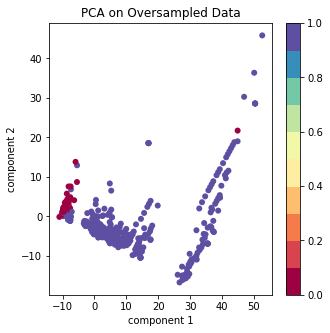

In [22]:
plt.figure(figsize=(5, 5))
plt.scatter(x_pca[:,0], x_pca[:,1], c=ytrain_over, edgecolor='none',
        cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA on Oversampled Data')
plt.colorbar()

In [30]:
x_df = pd.DataFrame(xtrain_over)
y_df = pd.DataFrame(ytrain_over)

In [31]:
x_df['Class'] = y_df

In [32]:
over_data = x_df

Text(0.5, 1.0, 'Oversampled Data')

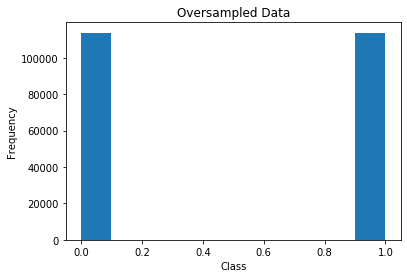

In [33]:
plt.hist(over_data['Class'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Oversampled Data')

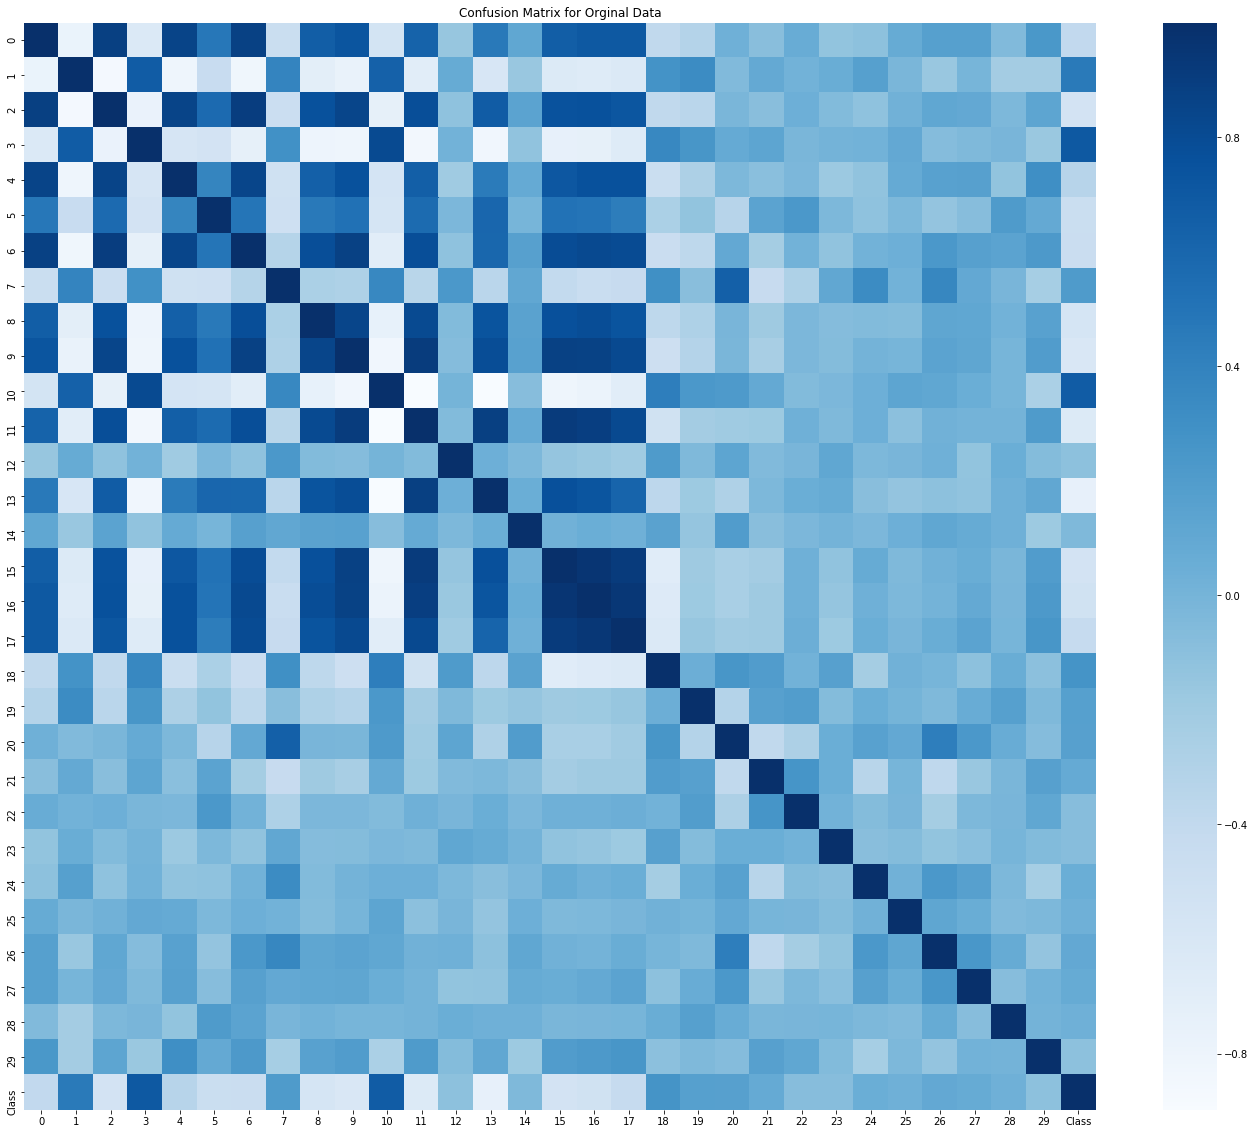

In [43]:
plt.figure(figsize=(24,20))
over_corr = over_data.corr()
sns.heatmap(over_corr, cmap='Blues')
plt.title('Confusion Matrix for Orginal Data')
plt.show()

### Support Vector Machine

In [44]:
from sklearn.svm import SVC
svc = SVC()

In [45]:
svc.fit(xtrain_over, ytrain_over)

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [46]:
ypred = svc.predict(xtest)

In [48]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.1288028948069237
AUROC score: 0.7842550220270956
Accuracy score: 0.9964537762016783
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28439
           1       0.22      0.57      0.32        42

    accuracy                           1.00     28481
   macro avg       0.61      0.78      0.66     28481
weighted avg       1.00      1.00      1.00     28481



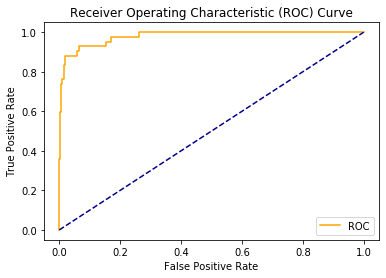

In [49]:
yscore = svc.decision_function(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore)
plot_roc_curve(fpr, tpr)

### Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
random_clf = RandomForestClassifier(random_state=0)

In [56]:
random_clf.fit(xtrain_over, ytrain_over)

C:\Users\Sandeep\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [57]:
ypred = random_clf.predict(xtest)

In [58]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.7481090257502603
AUROC score: 0.9165963407058382
Accuracy score: 0.9996137776061234
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28439
           1       0.90      0.83      0.86        42

    accuracy                           1.00     28481
   macro avg       0.95      0.92      0.93     28481
weighted avg       1.00      1.00      1.00     28481



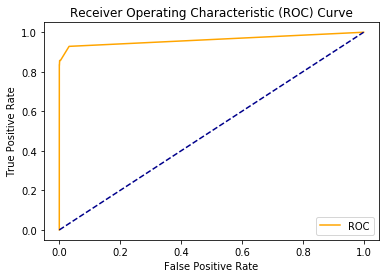

In [59]:
yscore = random_clf.predict_proba(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore[:,1])
plot_roc_curve(fpr, tpr)

### XGBoost

In [60]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [61]:
xgb.fit(xtrain_over, ytrain_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [95]:
xtest_df = pd.DataFrame(xtest)

In [96]:
xtest_df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Norm_Amount',
       'Norm_Time'],
      dtype='object')

In [97]:
xtest_df.columns = [i for i in range(0, xtest_df.shape[1])]

In [98]:
xtest = xtest_df.values

In [100]:
ypred = xgb.predict(xtest)

In [101]:
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))

AUPRC score: 0.07834159423127356
AUROC score: 0.9337952241974886
Accuracy score: 0.9864822162143183
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     28439
           1       0.09      0.88      0.16        42

    accuracy                           0.99     28481
   macro avg       0.54      0.93      0.58     28481
weighted avg       1.00      0.99      0.99     28481



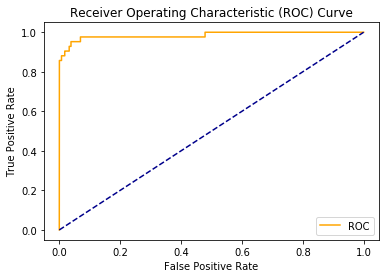

In [102]:
yscore = xgb.predict_proba(xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, yscore[:,1])
plot_roc_curve(fpr, tpr)